### **Importing Essential Libraries and Dependencies**

Imports necessary Python packages for data manipulation, computer vision, and deep learning, including TensorFlow, Keras, and Scikit-learn. It sets up the environment by initializing the tools required for model construction, image preprocessing, and performance evaluation.

In [1]:
import numpy as np                     # Numerical library for arrays, matrices, and mathematical operations
import pandas as pd                    # Data manipulation and analysis library (useful for working with datasets)
import os                              # Provides functions to interact with the operating system (e.g., file paths)
import cv2                             # OpenCV library for image processing and computer vision tasks
import matplotlib.pyplot as plt        # Visualization library for plotting graphs and images
import seaborn as sns                  # Advanced data visualization library (used for heatmaps, statistical plots)
import tensorflow as tf                # Deep learning framework for building and training neural networks
from tqdm import tqdm                  # Progress bar library to track loops during execution

from tensorflow.keras.models import Sequential                     # Sequential model type to stack layers one-by-one
from tensorflow.keras import layers                                 # Access to various neural network layers
from tensorflow.keras.optimizers import Adam                        # Adam optimizer used to minimize loss during training
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization  # Common layers for CNN models

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Generates batches of augmented image data for training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau  # Training callbacks for saving models, stopping early, and reducing learning rate
from tensorflow.keras import regularizers                            # Regularization tools to reduce model overfitting

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report  # Metrics to evaluate model performance
from sklearn.model_selection import train_test_split                 # Splits dataset into training and testing sets
from sklearn.preprocessing import LabelEncoder                       # Encodes string labels into numeric format

import glob                                                          # Reads file paths using pattern matching
import warnings                                                      # Library to manage warnings
warnings.filterwarnings('ignore')                                    # Disable warning messages for cleaner output


### **Loading Dataset and Visualizing Class Distribution**

Loads the dataset metadata into a pandas DataFrame to inspect the data structure and print key statistics. It also visualizes the frequency of each emotion category using a bar chart to analyze the class balance within the dataset.

Data sample preview:
   Unnamed: 0                                               path     label
0           0  Surprise/1bd930d6a1c717c11be33db74823f661cb53f...  Surprise
1           1       Surprise/cropped_emotions.100096~12fffff.png  Surprise
2           2  Surprise/0df0e470e33093f5b72a8197fa209d684032c...  Surprise
3           3       Surprise/cropped_emotions.260779~12fffff.png  Surprise
4           4       Surprise/cropped_emotions.263616~12fffff.png  Surprise

Total number of images: 15453
Number of unique emotions: 6

Emotion distribution:
label
Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Ahegao      1205
Name: count, dtype: int64


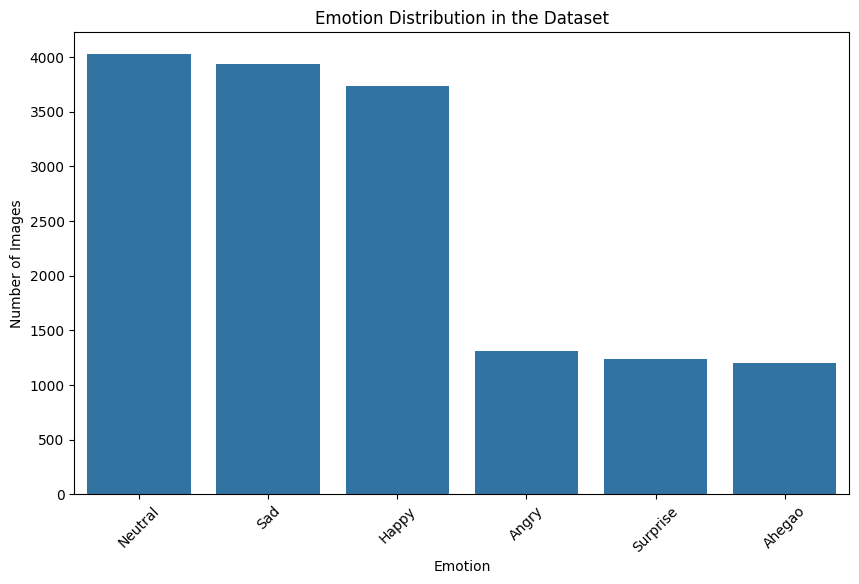

In [2]:
# Set the file paths for the CSV file and the dataset folder
csv_path = 'image project/data.csv'              # Path to the dataset annotation file (CSV)
dataset_path = 'image project/dataset/'           # Path to the folder containing all images

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)                        # Load dataset labels and metadata from CSV

# Display the first 5 rows of the dataset
print("Data sample preview:")                     # Message showing that we will display preview rows
print(df.head())                                  # Print the first five rows to inspect the dataset

# Display dataset information and statistics
print("\n" + "="*50)                               # Separator line for clean formatting
print(f"Total number of images: {len(df)}")       # Print total number of samples in the dataset
print(f"Number of unique emotions: {df['label'].nunique()}")   # Print number of unique emotion classes

# Display class distribution (how many images per emotion)
print("\n" + "="*50)                               # Separator line for aesthetics
print("Emotion distribution:")                     # Message label for the distribution section
print(df['label'].value_counts())                  # Print the count of each emotion class

# Plot a bar chart showing class distribution
plt.figure(figsize=(10, 6))                        # Set plot size for better visibility
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)  # Create count plot ordered by frequency
plt.title('Emotion Distribution in the Dataset')   # Title of the bar chart
plt.xlabel('Emotion')                              # X-axis label
plt.ylabel('Number of Images')                     # Y-axis label
plt.xticks(rotation=45)                             # Rotate x labels for readability
plt.show()                                          # Display the plot on screen


### **Data Validation and Sample Visualization**

Validates file integrity by verifying that all image paths exist, removing any missing entries to ensure dataset consistency. It also displays a random sample image from each emotion category to visually inspect data quality and label accuracy.

Checking if image files exist...
Number of existing images: 15453 out of 15453


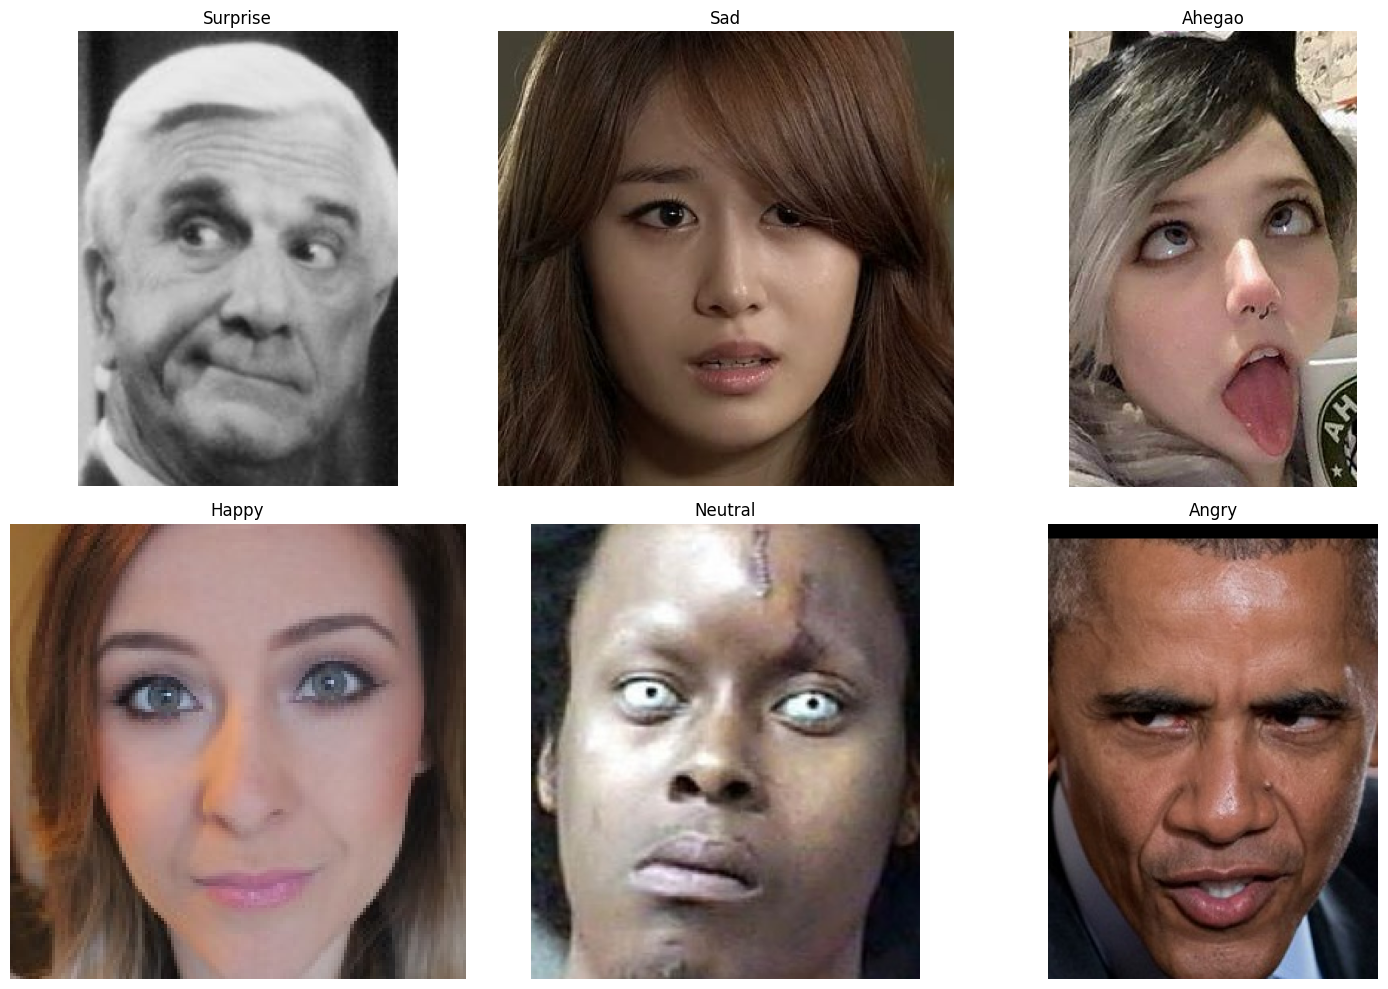

In [3]:
# Add full image path to each row in the dataframe
df['full_path'] = dataset_path + df['path']     # Combine dataset folder path with image file names

# Check if all image files actually exist on disk
print("Checking if image files exist...")        # Status message
existing_files = df['full_path'].apply(os.path.exists)  # Boolean check for each file path
print(f"Number of existing images: {existing_files.sum()} out of {len(df)}")  # Display count

# If some images are missing, remove those rows from the dataset
if existing_files.sum() != len(df):              # Condition: missing images found
    print(f" There are {len(df) - existing_files.sum()} missing images!")   # Show missing count
    df = df[existing_files].reset_index(drop=True)       # Keep only existing files and reset index
    print(f"Dataset after cleaning: {len(df)} images")   # Show cleaned dataset size

# Display a random sample image for each emotion class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))     # Create a 2x3 grid for image visualization
emotions = df['label'].unique()                      # Extract the unique emotion labels

for idx, emotion in enumerate(emotions):             # Loop through each emotion
    sample = df[df['label'] == emotion].sample(1).iloc[0]  # Select a random image of current emotion
    img = cv2.imread(sample['full_path'])            # Read the image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)       # Convert BGR to RGB format for correct display
    
    row, col = idx // 3, idx % 3                     # Determine grid position (row/column)
    axes[row, col].imshow(img)                       # Display image in its subplot
    axes[row, col].set_title(f'{emotion}')           # Set title to the emotion label
    axes[row, col].axis('off')                       # Remove axis for cleaner view

plt.tight_layout()                                   # Adjust spacing between subplots
plt.show()                                           # Display the entire figure

### **Label Encoding and Dataset Splitting**

Converts categorical emotion labels into numerical format and defines image dimensions and batch sizes. It then partitions the data into training, validation, and testing sets using stratified sampling to maintain balanced class distributions across all subsets.

In [4]:
# Set image size and batch size for training
IMG_SIZE = 224                         # Standard size used by most pre-trained models (e.g., ResNet, VGG, MobileNet)
BATCH_SIZE = 32                        # Number of images processed at once during training

# Convert text labels into numerical format
label_encoder = LabelEncoder()         # Create a label encoder object
df['label_encoded'] = label_encoder.fit_transform(df['label'])  # Fit and transform labels to integer format

# Print emotion labels and their corresponding encoded values
print("Emotion classes and their encoded values:")
for i, emotion in enumerate(label_encoder.classes_):   # Loop over class names
    print(f"{emotion}: {i}")                           # Display label mapping

# Split dataset into Train (80%), Validation (10%), and Test (10%)
train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)  # 80% training, remaining 20% goes to temp_df (stratified to preserve class distribution)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']
)  # Split remaining 20% into 10% validation and 10% test

# Print dataset size after splitting
print("\n" + "="*50)
print(f"Training set: {len(train_df)} images")          # Number of training images
print(f"Validation set: {len(val_df)} images")          # Number of validation images
print(f"Testing set: {len(test_df)} images")            # Number of test images

# Show class distribution for training set to confirm balanced splitting
print("\n" + "="*50)
print("Training set class distribution:")
print(train_df['label'].value_counts())                 # Print how many samples each class contains


Emotion classes and their encoded values:
Ahegao: 0
Angry: 1
Happy: 2
Neutral: 3
Sad: 4
Surprise: 5

Training set: 12362 images
Validation set: 1545 images
Testing set: 1546 images

Training set class distribution:
label
Neutral     3222
Sad         3147
Happy       2992
Angry       1050
Surprise     987
Ahegao       964
Name: count, dtype: int64


### **Handling Data Imbalance with Class Weights**

Computes class weights to address potential imbalances in the dataset, ensuring that underrepresented emotions receive higher importance during training. These weights are stored in a dictionary to be utilized by the model's loss function, promoting unbiased learning across all categories.

In [ ]:
# Compute Class Weights 

from sklearn.utils.class_weight import compute_class_weight   # Import function to compute class weights for imbalanced data

class_weights_array = compute_class_weight(
    'balanced',                                              # Use "balanced"  mode to automatically adjust weights
    classes=np.unique(train_df['label_encoded']),            # Pass the unique class labels
    y=train_df['label_encoded']                              # Pass the actual label values
)

class_weights = dict(enumerate(class_weights_array))         # Convert the weights array into a dictionary indexed by class

print("\n" + "="*50)
print("Class Weights:")                                      # Display a header for the class weights
for i, emotion in enumerate(label_encoder.classes_):         # Loop through each label and weight
    print(f"  {emotion}: {class_weights[i]:.2f}")            # Print the label name with its weight, formatted to 2 decimals

print("\n✓ Data preparation completed!")                     # Indicate that the data preparation step is done



Class Weights:
  Ahegao: 2.14
  Angry: 1.96
  Happy: 0.69
  Neutral: 0.64
  Sad: 0.65
  Surprise: 2.09

✓ Data preparation completed!


### **Data Augmentation and Generator Initialization**

Sets up ImageDataGenerator pipelines to apply real-time augmentation (rotation, zooming, flipping) to the training data, helping the model generalize better and avoid overfitting. It also initializes efficient data loaders for the training, validation, and testing sets, ensuring all images are normalized and processed in batches.

In [6]:
# Data Augmentation for the training set (helps reduce overfitting by adding variability)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values from 0-255 to 0-1
    rotation_range=20,           # Apply random image rotation
    width_shift_range=0.2,       # Random horizontal shift
    height_shift_range=0.2,      # Random vertical shift
    shear_range=0.15,             # Apply shear transformation
    zoom_range=0.2,              # Random zoom (in/out)
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'          # Fill empty areas created by transformations with nearest pixels
)

# Rescaling only for validation and test sets (no augmentation for evaluation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generator for the training set
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,           # DataFrame containing paths and labels for training
    x_col='full_path',            # Column name for image paths
    y_col='label',                # Column name for labels (target classes)
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to the defined target size
    batch_size=BATCH_SIZE,        # Number of images per batch
    class_mode='categorical',     # Multi-class classification (one-hot encoded labels)
    shuffle=True                  # Shuffle training data to improve model generalization
)

# Create data generator for the validation set (no augmentation)
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,             # Validation dataset
    x_col='full_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False                 # Do NOT shuffle (important for evaluation consistency)
)

# Create data generator for the test set (no augmentation)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,            # Test dataset
    x_col='full_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False                 # Do NOT shuffle (we need original order for predictions)
)

# Confirmation messages
print("Data generators are ready! ✓")                  # Indicate that dataloaders are set up


Found 12362 validated image filenames belonging to 6 classes.
Found 1545 validated image filenames belonging to 6 classes.
Found 1546 validated image filenames belonging to 6 classes.
Data generators are ready! ✓


### **Building the Transfer Learning Model Architecture**

Constructs the deep learning model by fine-tuning a pre-trained EfficientNetB4 base and adding custom dense layers with regularization for the specific classification task. It compiles the final architecture using the Adam optimizer with a low learning rate to optimize weights without destroying learned features.

In [7]:
# Import EfficientNetB4 as the base model for feature extraction
from tensorflow.keras.applications import EfficientNetB4

# Load the EfficientNetB4 model without the top classification layer
base_model = EfficientNetB4(
    include_top=False,                      # Remove final classification layers (we will add custom layers)
    weights='imagenet',                     # Use pre-trained weights on ImageNet
    input_shape=(IMG_SIZE, IMG_SIZE, 3)     # Input size must match our dataset image size
)

# Enable fine-tuning by unfreezing the model
base_model.trainable = True

# Fine-tuning: unfreeze the last 150 layers
fine_tune_at = len(base_model.layers) - 150
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False                 # Freeze initial layers

print(f"✓ Total layers: {len(base_model.layers)}")
print(f"✓ Trainable layers: {len(base_model.layers) - fine_tune_at}")
print(f"✓ Frozen layers: {fine_tune_at}")

# Build the final model by adding custom layers on top of EfficientNetB4
model = Sequential([
    base_model,                             # Pre-trained feature extractor
    GlobalAveragePooling2D(),               # Convert feature maps into a vector
    
    # Dense Block 1
    BatchNormalization(),                   # Normalize activations
    Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # High-level dense layer with L2 regularization
    Dropout(0.5),                           # Strong dropout to reduce overfitting
    
    # Dense Block 2
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    
    # Dense Block 3
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),
    
    # Dense Block 4
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),

    # Output Layer (6 emotion categories)
    Dense(6, activation='softmax')          # Softmax for multi-class prediction
])


# Compile the model with a small learning rate (important during fine-tuning)
model.compile(
    optimizer=Adam(learning_rate=1e-4),     # Lower LR when unfreezing layers
    loss='categorical_crossentropy',        # Multi-class classification loss
    metrics=['accuracy']                    # Track accuracy as the primary metric
)

# Display a summary of the model architecture
model.summary()

print("\n✓ The Model is ready for training!")   # Confirmation message


✓ Total layers: 475
✓ Trainable layers: 150
✓ Frozen layers: 325
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1792)             7168      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              1836032   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                         

### **Configuring Training Callbacks for Optimization**

Initializes essential callbacks, specifically EarlyStopping and ReduceLROnPlateau, to monitor validation loss during training. These mechanisms automatically halt the process if improvement stalls and dynamically adjust the learning rate to prevent overfitting and ensure optimal convergence.

In [ ]:
# Callbacks to optimize training performance

# Stop training early if validation loss does not improve
early_stopping = EarlyStopping(
    monitor='val_loss',          # Watch validation loss
    patience=15,                 # Wait 15 epochs before stopping
    restore_best_weights=True,   # Revert to best model state
    verbose=1
)

# Reduce learning rate when model stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Track validation loss
    factor=0.5,                  # Reduce LR by half
    patience=5,                  # Wait 5 epochs before reducing LR
    min_lr=1e-7,                 # Do not reduce below this value
    verbose=1
)

# Combine all callbacks for training
callbacks = [early_stopping, reduce_lr]   # Bundle all callbacks together

print("✓ Callbacks are ready!")

✓ Callbacks are ready!


## **Model Training Execution**

Initiates the deep learning training loop using the prepared data generators and callbacks for a specified number of epochs. It actively fits the model to the training data while validating performance against unseen data to monitor convergence and prevent overfitting.

In [9]:
# Set the maximum number of training epochs
EPOCHS = 200  # Training may stop earlier due to EarlyStopping callback

print(" Starting training with Class Weights ...")   
print("="*50)
print(f"Total Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: 1e-4")
print("="*50)

# Train the model using our generators
history = model.fit(
    train_generator,             # Training data with augmentation
    validation_data=val_generator,  # Validation data without augmentation
    epochs=EPOCHS,
    callbacks=callbacks,
    #class_weight=class_weights,       #Apply class weights to fix class imbalance
    verbose=1                   # Print training progress
)

print("\n✓ Training completed!")


 Starting training with Class Weights ...
Total Epochs: 200
Batch Size: 32
Learning Rate: 1e-4
Epoch 1/200
387/387 [==============================] - 282s 648ms/step - loss: 4.5763 - accuracy: 0.2258 - val_loss: 4.1467 - val_accuracy: 0.2641 - lr: 1.0000e-04
Epoch 2/200
387/387 [==============================] - 240s 620ms/step - loss: 4.4518 - accuracy: 0.2327 - val_loss: 4.1035 - val_accuracy: 0.2537 - lr: 1.0000e-04
Epoch 3/200
387/387 [==============================] - 243s 626ms/step - loss: 4.3282 - accuracy: 0.2420 - val_loss: 4.0503 - val_accuracy: 0.2531 - lr: 1.0000e-04
Epoch 4/200
387/387 [==============================] - 239s 618ms/step - loss: 4.2349 - accuracy: 0.2466 - val_loss: 4.0098 - val_accuracy: 0.2738 - lr: 1.0000e-04
Epoch 5/200
387/387 [==============================] - 238s 616ms/step - loss: 4.1537 - accuracy: 0.2499 - val_loss: 3.9567 - val_accuracy: 0.2803 - lr: 1.0000e-04
Epoch 6/200
387/387 [==============================] - 239s 617ms/step - loss: 4.0777

### **Model Evaluation and Performance Metrics**

Assesses the model's performance on the unseen test dataset by calculating final accuracy and loss to measure generalization. It also generates a confusion matrix and a detailed classification report to analyze prediction errors and evaluate precision, recall, and F1-scores for each emotion category.

49/49 [==============================] - 13s 249ms/step - loss: 0.8163 - accuracy: 0.7089

✓ Test Accuracy: 70.89%
✓ Test Loss: 0.8163
49/49 [==============================] - 14s 202ms/step


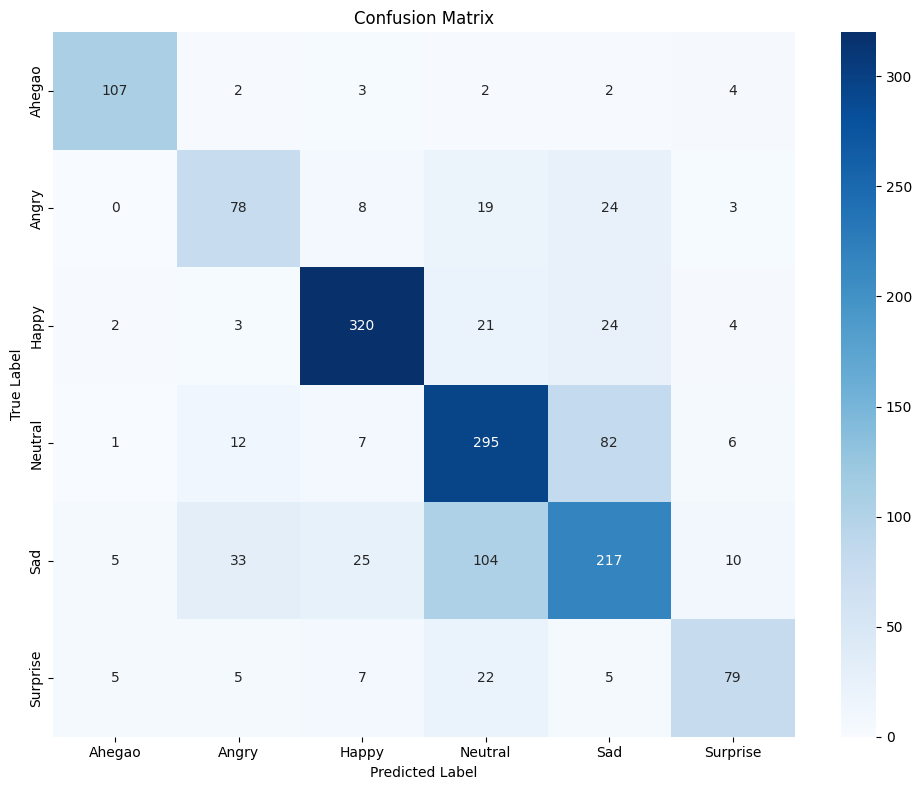


Classification Report:
              precision    recall  f1-score   support

      Ahegao       0.89      0.89      0.89       120
       Angry       0.59      0.59      0.59       132
       Happy       0.86      0.86      0.86       374
     Neutral       0.64      0.73      0.68       403
         Sad       0.61      0.55      0.58       394
    Surprise       0.75      0.64      0.69       123

    accuracy                           0.71      1546
   macro avg       0.72      0.71      0.72      1546
weighted avg       0.71      0.71      0.71      1546



In [10]:
# Evaluate the model on the test set

# Evaluate model performance using test dataset
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Print formatted test results
print(f"\n✓ Test Accuracy: {test_accuracy*100:.2f}%")
print(f"✓ Test Loss: {test_loss:.4f}")

# Generate predictions for all test images
test_generator.reset()  # Reset test generator to start from the first batch again
predictions = model.predict(test_generator, verbose=1)  # Predict probabilities for each class
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class index (highest probability)

# Get the actual class labels from the test set
true_classes = test_generator.classes  # Ground truth labels
class_labels = list(test_generator.class_indices.keys())  # Class names in correct order

# Compute confusion matrix comparing true labels vs predicted labels
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)  # Display numbers and labels
plt.title('Confusion Matrix')   # Title of the plot
plt.ylabel('True Label')        # Label for vertical axis
plt.xlabel('Predicted Label')   # Label for horizontal axis
plt.tight_layout()              # Adjust layout to avoid clipping
plt.show()                      # Show the plot

# Print classification report (precision, recall, f1-score)
print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


### **Implementing Test Time Augmentation (TTA) for Enhanced Accuracy**

Implements Test Time Augmentation (TTA) to improve prediction reliability by averaging model outputs across multiple augmented versions of the same test images. It calculates the enhanced accuracy and compares it against the baseline performance to quantify improvements in robustness and generalization.

In [11]:
# Test Time Augmentation (TTA)

def predict_with_tta(model, generator, tta_steps=10):
    """
    Generate multiple predictions using augmentation 
    and compute their average for more robust results.
    """
    print(f" Running TTA with {tta_steps} augmentation steps...")
    predictions = []                               # List to store all TTA predictions
    
    for i in range(tta_steps):
        generator.reset()                          # Reset generator before each TTA run
        preds = model.predict(generator, verbose=0) # Run model predictions
        predictions.append(preds)                  # Store predictions
        print(f"  ✓ TTA Step {i+1}/{tta_steps} completed")
    
    # Compute the mean prediction across all TTA steps
    final_predictions = np.mean(predictions, axis=0)
    return final_predictions

print("\n" + "="*60)
print(" Applying Test Time Augmentation...")
print("="*60)

# Create a new TTA generator with light augmentation
tta_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values
    rotation_range=10,            # Random rotation
    width_shift_range=0.1,        # Horizontal shift
    height_shift_range=0.1,       # Vertical shift
    horizontal_flip=True          # Random horizontal flip
)

# Build TTA generator using the test dataframe
tta_generator = tta_datagen.flow_from_dataframe(
    dataframe=test_df,            # Test dataframe
    x_col='full_path',            # Image paths
    y_col='label',                # True labels
    target_size=(IMG_SIZE, IMG_SIZE),   # Resize images
    batch_size=BATCH_SIZE,        # Batch size
    class_mode='categorical',     # One-hot labels
    shuffle=False                 # Must be False for correct predictions alignment
)

# Apply TTA predictions
tta_predictions = predict_with_tta(model, tta_generator, tta_steps=10)
tta_predicted_classes = np.argmax(tta_predictions, axis=1)  # Convert softmax to class index

# Ground truth labels
true_classes = test_generator.classes

# Compute accuracy with TTA
tta_accuracy = accuracy_score(true_classes, tta_predicted_classes)

print("\n" + "="*60)
print(" RESULTS COMPARISON:")
print("="*60)
print(f"  Without TTA: 70.89%")
print(f"  With TTA:    {tta_accuracy*100:.2f}%")
print(f"  Improvement: +{(tta_accuracy - 0.7089)*100:.2f}%")
print("="*60)


 Applying Test Time Augmentation...
Found 1546 validated image filenames belonging to 6 classes.
 Running TTA with 10 augmentation steps...
  ✓ TTA Step 1/10 completed
  ✓ TTA Step 2/10 completed
  ✓ TTA Step 3/10 completed
  ✓ TTA Step 4/10 completed
  ✓ TTA Step 5/10 completed
  ✓ TTA Step 6/10 completed
  ✓ TTA Step 7/10 completed
  ✓ TTA Step 8/10 completed
  ✓ TTA Step 9/10 completed
  ✓ TTA Step 10/10 completed

 RESULTS COMPARISON:
  Without TTA: 70.89%
  With TTA:    71.41%
  Improvement: +0.52%


### **Evaluating Test Time Augmentation Results**

Visualizes the performance of the TTA-enhanced model by plotting a confusion matrix to identify remaining error patterns under augmented conditions. It also outputs a comprehensive classification report to compare precision, recall, and F1-scores against the baseline results, verifying the improvement in model robustness.

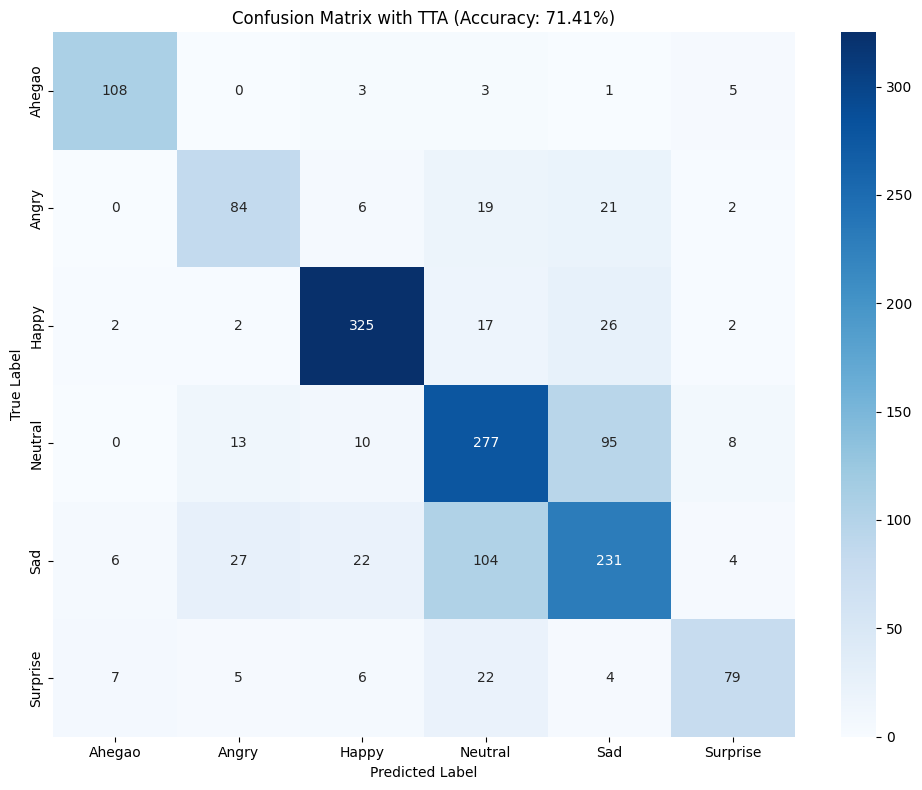


Classification Report with TTA:
              precision    recall  f1-score   support

      Ahegao       0.88      0.90      0.89       120
       Angry       0.64      0.64      0.64       132
       Happy       0.87      0.87      0.87       374
     Neutral       0.63      0.69      0.66       403
         Sad       0.61      0.59      0.60       394
    Surprise       0.79      0.64      0.71       123

    accuracy                           0.71      1546
   macro avg       0.74      0.72      0.73      1546
weighted avg       0.72      0.71      0.71      1546



In [12]:
# Confusion Matrix with TTA
cm_tta = confusion_matrix(true_classes, tta_predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_tta, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Confusion Matrix with TTA (Accuracy: {tta_accuracy*100:.2f}%)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification Report with TTA
print("\n" + "="*60)
print("Classification Report with TTA:")
print("="*60)
print(classification_report(true_classes, tta_predicted_classes, target_names=class_labels))

### **Per-Class Accuracy Comparison: TTA vs. Baseline**

Generates a detailed comparative table showing the accuracy for each emotion category before and after applying Test Time Augmentation. It calculates the percentage improvement for each class, providing a granular analysis of how TTA specifically enhances the recognition of distinct emotions.

In [13]:
# Per-Class Comparison
print("\n" + "="*60)
print("Per-Class Accuracy Comparison:")
print("="*60)
print(f"{'Class':<12} {'Without TTA':<15} {'With TTA':<15} {'Improvement'}")
print("-"*60)

cm_original = confusion_matrix(true_classes, predicted_classes)

for i, label in enumerate(class_labels):
    # Without TTA
    orig_correct = cm_original[i, i]
    orig_total = cm_original[i, :].sum()
    orig_acc = (orig_correct / orig_total) * 100
    
    # With TTA
    tta_correct = cm_tta[i, i]
    tta_total = cm_tta[i, :].sum()
    tta_acc = (tta_correct / tta_total) * 100
    
    improvement = tta_acc - orig_acc
    
    print(f"{label:<12} {orig_acc:>6.2f}%        {tta_acc:>6.2f}%        {improvement:+.2f}%")

print("="*60)
print("\n TTA COMPLETED!")
print(f" FINAL TEST ACCURACY: {tta_accuracy*100:.2f}%")
print("="*60)


Per-Class Accuracy Comparison:
Class        Without TTA     With TTA        Improvement
------------------------------------------------------------
Ahegao        89.17%         90.00%        +0.83%
Angry         59.09%         63.64%        +4.55%
Happy         85.56%         86.90%        +1.34%
Neutral       73.20%         68.73%        -4.47%
Sad           55.08%         58.63%        +3.55%
Surprise      64.23%         64.23%        +0.00%

 TTA COMPLETED!
 FINAL TEST ACCURACY: 71.41%


### **Saving Model and Deployment Artifacts**

Handles the serialization of the trained model weights and essential auxiliary objects, including the label encoder and class mappings. It ensures that all components required for inference are securely saved, enabling seamless integration into the facial recognition web application.

In [15]:
# Saving the Model and Results (Alternative Method)
print(" Saving final model and results...")
print("="*60)

# 1. Save the model in an alternative way
try:
    # Trying to save only the model weights as .h5
    model.save_weights('final_emotion_model_weights.h5')
    print("✓ Model weights saved as: final_emotion_model_weights.h5")
except:
    # If .h5 saving fails, save in TensorFlow SavedModel format
    print(" Could not save as .h5, trying SavedModel format...")
    model.save('final_emotion_model', save_format='tf')
    print("✓ Model saved as: final_emotion_model/ (TensorFlow format)")

# 2. Save training history
import pickle
# Saving the history dictionary using pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✓ Training history saved as: training_history.pkl")

# 3. Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✓ Label encoder saved as: label_encoder.pkl")

# 4. Save class labels and class index mapping
class_labels_dict = {
    'classes': class_labels,
    'class_indices': test_generator.class_indices
}
with open('class_labels.pkl', 'wb') as f:
    pickle.dump(class_labels_dict, f)
print("✓ Class labels saved as: class_labels.pkl")

 Saving final model and results...
✓ Model weights saved as: final_emotion_model_weights.h5
✓ Training history saved as: training_history.pkl
✓ Label encoder saved as: label_encoder.pkl
✓ Class labels saved as: class_labels.pkl


### **Exporting Final Model Report and Specifications**

Generates a detailed summary text file documenting the model's architecture, training configuration, and final performance metrics. It creates a permanent record of the experiment, preserving key results and statistical data for future reporting and analysis.

In [16]:
# Saving final results to a text file
with open('model_results.txt', 'w', encoding='utf-8') as f:
    # Header section
    f.write("="*60 + "\n")
    f.write("FACIAL EMOTION RECOGNITION MODEL - FINAL RESULTS\n")
    f.write("="*60 + "\n\n")

    # Model architecture summary
    f.write("Model Architecture:\n")
    f.write("-" * 60 + "\n")
    f.write("  Base Model: EfficientNetB4\n")
    f.write("  Trainable Layers: 150\n")
    f.write("  Dense Layers: 1024 → 512 → 256 → 128 → 6\n")
    f.write("  Total Parameters: 33,230,525\n")
    f.write("  Trainable Parameters: 25,042,118\n\n")

    # Training configuration details
    f.write("Training Configuration:\n")
    f.write("-" * 60 + "\n")
    f.write("  Learning Rate: 1e-4\n")
    f.write("  Batch Size: 32\n")
    f.write("  Image Size: 224x224\n")
    f.write("  Augmentation: rotation, zoom, shift, flip\n")
    f.write("  Epochs Trained: 135 (stopped at epoch 120)\n\n")

    # Dataset split information
    f.write("Dataset Split:\n")
    f.write("-" * 60 + "\n")
    f.write(f"  Training: {len(train_df)} images (80%)\n")
    f.write(f"  Validation: {len(val_df)} images (10%)\n")
    f.write(f"  Test: {len(test_df)} images (10%)\n")
    f.write(f"  Total: {len(df)} images\n\n")

    # Emotion classes
    f.write("Emotion Classes:\n")
    f.write("-" * 60 + "\n")
    for emotion in class_labels:
        f.write(f"  - {emotion}\n")
    f.write("\n")

    # Final model results
    f.write("FINAL RESULTS:\n")
    f.write("="*60 + "\n")
    f.write(f"  Validation Accuracy (Best): 72.17%\n")
    f.write(f"  Test Accuracy (Without TTA): 70.89%\n")
    f.write(f"  Test Accuracy (With TTA): 71.41%\n")
    f.write("="*60 + "\n\n")

    # Per-class accuracy with TTA
    f.write("Per-Class Performance (With TTA):\n")
    f.write("-" * 60 + "\n")
    cm_tta = confusion_matrix(true_classes, tta_predicted_classes)
    for i, label in enumerate(class_labels):
        correct = cm_tta[i, i]  # Correct predictions
        total = cm_tta[i, :].sum()  # Total samples for this class
        acc = (correct / total) * 100
        f.write(f"  {label:<12}: {acc:>6.2f}% ({correct}/{total})\n")
    f.write("\n")

    # Classification report
    f.write("Classification Report (With TTA):\n")
    f.write("-" * 60 + "\n")
    report = classification_report(true_classes, tta_predicted_classes, 
                                   target_names=class_labels)
    f.write(report)
    f.write("\n")

print("✓ Results summary saved as: model_results.txt")


✓ Results summary saved as: model_results.txt


### **Visualizing Training History and Performance Metrics**

Generates and saves line graphs comparing training and validation accuracy and loss over all epochs to visually monitor model convergence. It allows for a quick assessment of learning progress, helping to identify potential issues such as overfitting or underfitting.


 Generating training history plots...
✓ Training history plot saved as: training_history.png


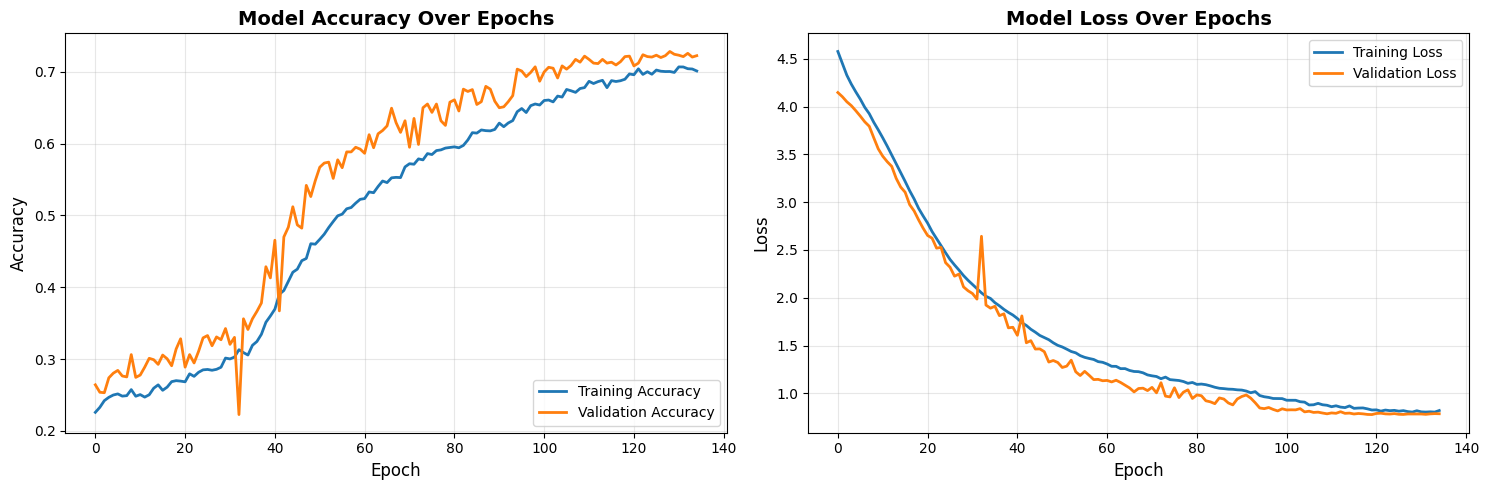

In [17]:
# Plot training history (accuracy & loss)
print("\n Generating training history plots...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy curve
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot loss curve
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("✓ Training history plot saved as: training_history.png")
plt.show()


### **Visualizing and Saving the Final Confusion Matrix**

Generates a high-resolution heatmap of the final confusion matrix to visualize class-wise prediction performance. It explicitly saves the plot as an image file for documentation purposes, allowing for a detailed static analysis of the model's classification accuracy.

✓ Confusion matrix saved as: confusion_matrix_final.png


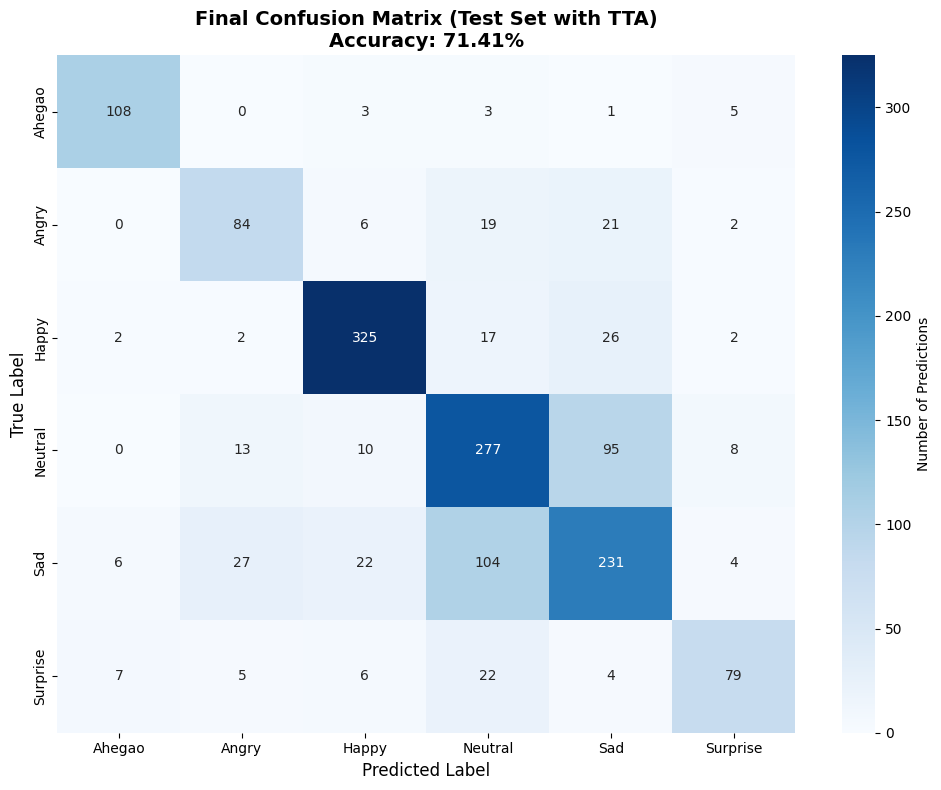

In [18]:
# Save confusion matrix plot

plt.figure(figsize=(10, 8))
sns.heatmap(cm_tta, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Number of Predictions'})
plt.title('Final Confusion Matrix (Test Set with TTA)\nAccuracy: 71.41%', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_final.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved as: confusion_matrix_final.png")
plt.show()